In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

# !pip install eli5
import eli5

# Задание

Набор данных пациентов раком печени(Гепатоцеллюлярная карцинома).  
Первый столбец - индекс с номерами строк. Последний столбец - Class - выжил пациент(1) или нет(0).

Особенности:
1. Некоторые ячейки содержат значения NaN.
2. Многие столбцы содержат только значения 0/1(да/нет) или женщина/мужчина для столбца Gender
3. Некоторые столбцы содержат категориальные порядковые значения(0/1/2/3/4) 


Столбцы до Age_at_diagnosis - бинарные(номинальные)
Age_at_diagnosis - число
Столбцы Performance_Status, Encefalopathy_degree, Ascites_degree - порядковые категории
Последующие столбцы - числа.


** Задача - построить с помощью разобранных нами алгоритмов модель, предсказывающую столбец Class - выживаемость для пациента. **

Можно пользоваться любыми приёмами из мат. статистики и вообще всего пройденного - кластеризовать и разглядывать данные(а потом по ним принимать решения), заполнять по-разному пропуски.

In [2]:
data = pd.read_csv('train.csv', index_col='index', )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 50 columns):
Gender                            100 non-null int64
Symptoms                          91 non-null float64
Alcohol                           100 non-null int64
Hepatitis_B_Surface_Antigen       89 non-null float64
Hepatitis_B_e_Antigen             76 non-null float64
Hepatitis_B_Core_Antibody         86 non-null float64
Hepatitis_C_Virus_Antibody        94 non-null float64
Cirrhosis                         100 non-null int64
Endemic_Countries                 82 non-null float64
Smoking                           77 non-null float64
Diabetes                          99 non-null float64
Obesity                           98 non-null float64
Hemochromatosis                   87 non-null float64
Arterial_Hypertension             99 non-null float64
Chronic_Renal_Insufficiency       99 non-null float64
Human_Immunodeficiency_Virus      92 non-null float64
Nonalcoholic_Steatohepatitis      8

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,100.0,0.820000,0.386123,0.00,1.0000,1.000,1.0000,1.00
Symptoms,91.0,0.670330,0.472698,0.00,0.0000,1.000,1.0000,1.00
Alcohol,100.0,0.780000,0.416333,0.00,1.0000,1.000,1.0000,1.00
Hepatitis_B_Surface_Antigen,89.0,0.123596,0.330984,0.00,0.0000,0.000,0.0000,1.00
Hepatitis_B_e_Antigen,76.0,0.013158,0.114708,0.00,0.0000,0.000,0.0000,1.00
Hepatitis_B_Core_Antibody,86.0,0.313953,0.466820,0.00,0.0000,0.000,1.0000,1.00
Hepatitis_C_Virus_Antibody,94.0,0.191489,0.395583,0.00,0.0000,0.000,0.0000,1.00
Cirrhosis,100.0,0.900000,0.301511,0.00,1.0000,1.000,1.0000,1.00
Endemic_Countries,82.0,0.085366,0.281145,0.00,0.0000,0.000,0.0000,1.00
Smoking,77.0,0.480519,0.502897,0.00,0.0000,0.000,1.0000,1.00


In [5]:
data.head(3)

,Gender,Symptoms,Alcohol,Hepatitis_B_Surface_Antigen,Hepatitis_B_e_Antigen,Hepatitis_B_Core_Antibody,Hepatitis_C_Virus_Antibody,Cirrhosis,Endemic_Countries,Smoking,...,Alkaline_phosphatase,Total_Proteins,Creatinine,Number_of_Nodules,Major_dimension_of_nodule,Direct_Bilirubin,Iron,Oxygen_Saturation,Ferritin,Class
index,,,,,,,,,,,,,,,,,,,,,
0,1,1.0,0,0.0,0.0,0.0,0.0,0,0.0,1.0,...,171.0,7.5,1.38,1.0,19.0,NaN,45.0,21.00,802.0,0
1,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,NaN,...,88.0,5.6,NaN,5.0,4.7,0.5,19.0,8.00,141.0,1
2,0,NaN,0,0.0,0.0,1.0,1.0,1,0.0,0.0,...,104.0,8.5,0.74,2.0,3.3,0.3,143.0,50.18,120.0,1


Заменим мультиклассовые фичи бинарными

In [6]:
multi_cat_fea = 'Performance_Status Encefalopathy_degree Ascites_degree'.split()

In [7]:
data[multi_cat_fea] = data[multi_cat_fea].astype(int)
data.shape

(100, 50)

In [8]:
data = pd.get_dummies(data, columns=multi_cat_fea,)
data.shape

(100, 58)

Поместим все категориальные признаки в один массив, а числовые - в другой

In [9]:
cat_features = data.columns[data.apply(pd.Series.nunique, axis=0) == 2].values
num_features = np.array(list(set(data.columns) - set(cat_features)))
num_features.shape[0] + cat_features.shape[0]

58

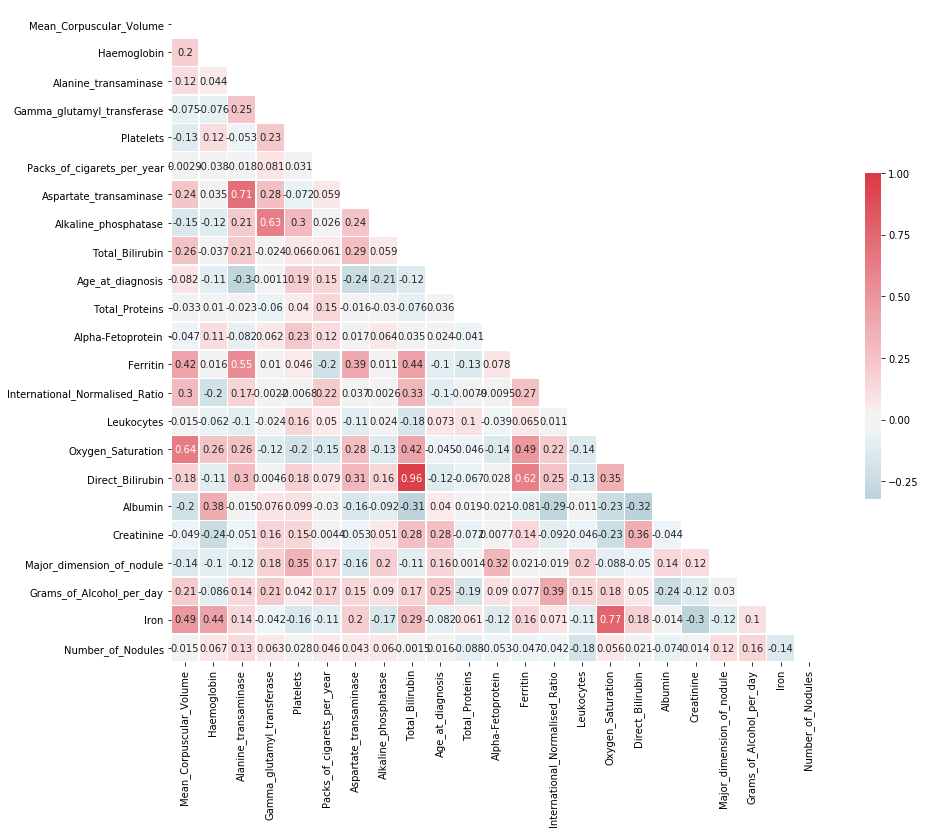

In [10]:
# Compute the correlation matrix
corr = data[num_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# _ = plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, )

Можно убрать _Direct_Bilirubin_, данных о нем меньше, ну или попытаться его предсказать и использовать

In [11]:
# for col_name in num_features:
#     sns.boxplot('Class', col_name, data=data)
#     plt.title(f'{col_name}')
#     plt.show()

Что-то влияет заметно, что-то нет. Но совсем яркой зависимости нет

In [12]:
# for col_name in cat_features:
#     sns.barplot('Class', col_name, data=data)
#     plt.title(f'{col_name}')
#     plt.show()

Сделаем Х и Y; и отскалим числовые признаки

In [13]:
data_X = data.drop('Class', axis=1)
Y = data.Class

# Scaling
for col in num_features:
    data_X[col] = (data_X[col] - data_X[col].mean()) / (data_X[col].std() + 1e-7)

------

Голая регрессия, будем ею сравнивать в последующем качество предсказания с разными фичами

In [14]:
stock_X = data_X.copy()

In [64]:
def Logit_class_predict(X, Y, ow=True, verbose=True):
    X = X.copy()
    logit = LogisticRegression()
    clear_X = X.dropna(axis=1)
    dsc = cross_val_score(logit, clear_X, Y, scoring='roc_auc', n_jobs=4, cv=9)
    logit.fit(clear_X, Y)
    W = eli5.show_weights(estimator=logit, feature_names=list(clear_X.columns))
    if verbose:
        print('len =', clear_X.shape[1], 'mean =', dsc.mean(), 'sd =', dsc.std())
    if ow:
        return W
    return dsc.mean()

In [65]:
Logit_class_predict(stock_X, Y)

len = 15 mean = 0.6112433862433861 sd = 0.13056835358595845


Weight?,Feature
+0.871,Performance_Status_0
+0.569,Encefalopathy_degree_2
+0.559,Performance_Status_2
+0.335,Ascites_degree_1
+0.233,Gender
+0.232,Alcohol
-0.094,Performance_Status_1
-0.131,Ascites_degree_2
-0.142,<BIAS>
-0.238,Cirrhosis


------

In [17]:
def predict_binary_NaN_values(col_name, data, use_cols):
    """Предскажет колонку бинарных признаков (col_name), если ей дать фрейм данных (data) и указать, какие 
    фичи использовать для предсказания (use_cols); берем те, у которых есть все значения;
    Использует 2 классификатора и выбирает лучший с лучшими параметрами
    Возвращает всю колонку, которую предсказывали и грубое количество допустимых ошибок при предсказании
    """
    data = data.copy()
    clf = ExtraTreesClassifier(criterion='entropy')
    parameters = {
        'n_estimators': [50,100,150],
        'max_depth': [None, 8, 9, 11, 12],
        'max_features': [None, 'sqrt', 'log2'],
    }    def Logit_class_predict(X, Y, ow=True):
    X = X.copy()
    logit = LogisticRegression()
    clear_X = X.dropna(axis=1)
    dsc = cross_val_score(logit, clear_X, Y, scoring='roc_auc', n_jobs=4, cv=9)
    logit.fit(clear_X, Y)
    W = eli5.show_weights(estimator=logit, feature_names=list(clear_X.columns))
    print('len =', clear_X.shape[1], 'mean =', dsc.mean(), 'sd =', dsc.std())
    if ow:
        return W
    logit_clf = LogisticRegression()
    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    L_parameters = dict(C=C, penalty=penalty)
    
    X_test = data[use_cols][data[col_name].isna()]
    X_train = data[use_cols][- data[col_name].isna()]
    y_all = data[col_name]
    y_train = y_all[- data[col_name].isna()]
    
    skf = StratifiedKFold(5, random_state=1024) # если делать без этого, будет исключения выбрасывать разные,
#                                                 если еще меньше 5 одного из классов
    fgrid_clf = GridSearchCV(clf, cv=skf, scoring='roc_auc', n_jobs=4, param_grid=parameters)
    fgrid_clf.fit(X_train, y_train)
    fscore = fgrid_clf.best_score_
    
    lgrid_clf = GridSearchCV(logit_clf, cv=skf, scoring='roc_auc', n_jobs=4, param_grid=L_parameters)   
    lgrid_clf.fit(X_train, y_train)
    lscore = lgrid_clf.best_score_
    
    bst_clf = lgrid_clf.best_estimator_
    score = lscore
    if fscore > lscore:
        bst_clf = fgrid_clf.best_estimator_
        score = fscore
        
    bst_clf.fit(X_train, y_train)
    y_pred = bst_clf.predict(X_test)
    y_all[data[col_name].isna()] = y_pred
    error = len(y_pred) * (1 - score)
    
    return y_all, error

In [18]:
complete_fea = list(data_X.dropna(axis=1).columns)
cat_to_predict = list(data[cat_features].count()[data.count() < 100].sort_values(ascending=False).index)
num_to_predict = list(data[num_features].count()[data.count() < 100].sort_values(ascending=False).index)

f'{len(complete_fea)} + {len(cat_to_predict)} + {len(num_to_predict)} = \
{len(complete_fea) + len(cat_to_predict) + len(num_to_predict)}, and Class'

'15 + 20 + 22 = 57, and Class'

Посмотрим на распределение в бинарных колонках, отобразим только едицицы

In [19]:
for col in cat_to_predict:
    print(f'{col} {(30-len(col))*" "} {data_X[col].value_counts()[1]}')

Diabetes                        29
Chronic_Renal_Insufficiency     12
Arterial_Hypertension           35
Radiological_Hallmark           65
Obesity                         8
Portal_Vein_Thrombosis          24
Liver_Metastasis                23
Hepatitis_C_Virus_Antibody      18
Splenomegaly                    51
Portal_Hypertension             67
Human_Immunodeficiency_Virus    1
Symptoms                        61
Nonalcoholic_Steatohepatitis    4
Hepatitis_B_Surface_Antigen     11
Hemochromatosis                 2
Hepatitis_B_Core_Antibody       27
Endemic_Countries               7
Smoking                         37
Hepatitis_B_e_Antigen           1
Esophageal_Varices              39


Для Human_Immunodeficiency_Virus, Hemochromatosis, Hepatitis_B_e_Antigen, Nonalcoholic_Steatohepatitis совсем мало больных, заполним нулями NaN

In [20]:
for col in 'Hepatitis_B_e_Antigen Human_Immunodeficiency_Virus \
            Hemochromatosis Nonalcoholic_Steatohepatitis'.split():
    data_X[col] = data_X[col].fillna(0)
    cat_to_predict.remove(col)
    complete_fea.append(col)

In [21]:
f'{len(complete_fea)} + {len(cat_to_predict)} + {len(num_to_predict)} = \
{len(complete_fea) + len(cat_to_predict) + len(num_to_predict)}'

'19 + 16 + 22 = 57'

Cначала посчитаем какие фичи предсказываются лучше всего. Потом отсортируем их по количеству возможных ошибок (длина предсказанного вектора * скор ошибки), и новым циклом будем предсказывать начиная лучшие и добавлять новые колонки с заполненными значениями

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
%%time
errors = []
for col in cat_to_predict:
    ny, er = predict_binary_NaN_values(col, data_X, complete_fea)
    print(col, (30-len(col))*" ", round(er,3))
    errors.append((col, er))

Diabetes                        0.308
Chronic_Renal_Insufficiency     0.174
Arterial_Hypertension           0.262
Radiological_Hallmark           0.751
Obesity                         0.762
Portal_Vein_Thrombosis          0.547
Liver_Metastasis                0.775
Hepatitis_C_Virus_Antibody      1.037
Splenomegaly                    2.174
Portal_Hypertension             1.22
Symptoms                        4.221
Hepatitis_B_Surface_Antigen     2.625
Hepatitis_B_Core_Antibody       3.629
Endemic_Countries               4.888
Smoking                         7.22
Esophageal_Varices              9.001
CPU times: user 10.2 s, sys: 238 ms, total: 10.4 s
Wall time: 3min 59s


In [24]:
f'Итого будет около {sum(list(map(lambda x: x[1], errors)))} ошибок, внесенных нами'

'Итого будет около 39.59428392381364 ошибок, внесенных нами'

-----

In [25]:
sorted_cat_to_predict = list(map(lambda x: x[0], sorted(errors, key=lambda x: x[1])))

Внесем эти ошибки!

In [26]:
%%time
mod_errors = []
for col in sorted_cat_to_predict:
    ny, er = predict_binary_NaN_values(col, data_X, complete_fea)
    data_X[col] = ny # заполняем пропуски
    complete_fea.append(col) # теперь и эта колонка будет использоваться для предсказаний 
    mod_errors.append(er)
    print(col, (30-len(col))*" ", round(er,3))

Chronic_Renal_Insufficiency     0.174
Arterial_Hypertension           0.269
Diabetes                        0.211
Portal_Vein_Thrombosis          0.601
Radiological_Hallmark           0.726
Obesity                         0.999
Liver_Metastasis                0.927
Hepatitis_C_Virus_Antibody      2.256
Portal_Hypertension             1.125
Splenomegaly                    1.431
Hepatitis_B_Surface_Antigen     2.424
Hepatitis_B_Core_Antibody       1.524
Symptoms                        3.575
Endemic_Countries               1.698
Smoking                         8.417
Esophageal_Varices              2.921
CPU times: user 10.9 s, sys: 256 ms, total: 11.1 s
Wall time: 4min 17s


In [27]:
print(f'В итоге внесено где-то {sum(mod_errors)} ошибок')

В итоге внесено где-то 29.277270047830324 ошибок


Колонки с большим числом пропусков неплохо сократили количество ошибок при последовательном добавлении заполненных колонок

In [28]:
f'{len(complete_fea)} + {len(num_to_predict)} = {len(complete_fea) + len(num_to_predict)} and Class'

'35 + 22 = 57 and Class'

------

Попробуем предсказать на заполненных бинарных фичах целевую

In [29]:
stock_and_binary_X = data_X.copy() 

In [66]:
Logit_class_predict(stock_and_binary_X, Y)

len = 35 mean = 0.7723544973544973 sd = 0.14730485613352867


Значение сильно подросло в среднем, т.е. положительное влияние заполнения на лицо. По коэффициентам видим, что те у кого обнаружены антигены, скорее умерли, а те у кого антитела, наоборот, о чем написано и в википедии

------

А теперь то же самое с числовыми фичами

In [37]:
def predict_numeric_NaN_values(col_name, data, use_cols):
    data = data.copy()
    rsr = ExtraTreesRegressor(criterion='mae', )
    parameters = {
        'n_estimators': [50,100,150],
        'max_depth': [None, 8, 9, 11, 12],
        'max_features': [None, 'sqrt', 'log2'],
    }    
    ridge = Ridge()
    r_parameters = {'alpha': [50,100,150]}    
    
    X_test = data[use_cols][data[col_name].isna()]
    X_train = data[use_cols][- data[col_name].isna()]
    y_all = data[col_name]
    y_train = y_all[- data[col_name].isna()]
    
    fgrid_clf = GridSearchCV(rsr, cv=5, scoring='neg_mean_absolute_error', n_jobs=4, param_grid=parameters)
    fgrid_clf.fit(X_train, y_train)
    fscore = fgrid_clf.best_score_
    
    rgrid_clf = GridSearchCV(ridge, cv=5, scoring='neg_mean_absolute_error', n_jobs=4, param_grid=r_parameters)
    rgrid_clf.fit(X_train, y_train)
    rscore = rgrid_clf.best_score_
    
    bst_clf = fgrid_clf.best_estimator_
    score = fscore
    if rscore < fscore:
        bst_clf = rgrid_clf.best_estimator_
        score = rscore
        
    bst_clf.fit(X_train, y_train)
    y_pred = bst_clf.predict(X_test)
    y_all[data[col_name].isna()] = y_pred
    
    return y_all, -score

In [38]:
%%time
mae_errors = []
for col in num_to_predict:
    ny, er = predict_numeric_NaN_values(col, data_X, complete_fea)
    print(col, (30-len(col))*" ", round(er,3))
    mae_errors.append((col, er))

Number_of_Nodules               0.935
International_Normalised_Ratio  0.617
Haemoglobin                     0.826
Gamma_glutamyl_transferase      0.808
Platelets                       0.802
Aspartate_transaminase          0.619
Alkaline_phosphatase            0.675
Total_Bilirubin                 0.537
Mean_Corpuscular_Volume         0.831
Leukocytes                      0.749
Alanine_transaminase            0.658
Albumin                         0.787
Creatinine                      0.559
Alpha-Fetoprotein               0.361
Total_Proteins                  0.344
Major_dimension_of_nodule       0.75
Direct_Bilirubin                0.508
Packs_of_cigarets_per_year      0.729
Grams_of_Alcohol_per_day        0.694
Ferritin                        0.74
Iron                            0.794
Oxygen_Saturation               0.79
CPU times: user 22 s, sys: 4.19 s, total: 26.2 s
Wall time: 8min 44s


In [39]:
sorted_num_to_predict = list(map(lambda x: x[0], sorted(mae_errors, key=lambda x: x[1])))

In [40]:
%%time
mod_mae_errors = []
for col in sorted_num_to_predict:
    ny, er = predict_numeric_NaN_values(col, data_X, complete_fea)
    data_X[col] = ny # заполняем пропуски
    complete_fea.append(col) # теперь и эта колонка будет использоваться для предсказаний 
    mod_mae_errors.append(er)
    print(col, (30-len(col))*" ", round(er,3))

Total_Proteins                  0.344
Alpha-Fetoprotein               0.361
Direct_Bilirubin                0.517
Total_Bilirubin                 0.376
Creatinine                      0.55
International_Normalised_Ratio  0.589
Aspartate_transaminase          0.624
Alanine_transaminase            0.485
Alkaline_phosphatase            0.673
Grams_of_Alcohol_per_day        0.651
Packs_of_cigarets_per_year      0.745
Ferritin                        0.653
Leukocytes                      0.75
Major_dimension_of_nodule       0.777
Albumin                         0.813
Oxygen_Saturation               0.71
Iron                            0.666
Platelets                       0.774
Gamma_glutamyl_transferase      0.625
Haemoglobin                     0.743
Mean_Corpuscular_Volume         0.726
Number_of_Nodules               0.965
CPU times: user 24.5 s, sys: 4.15 s, total: 28.6 s
Wall time: 10min 37s


In [41]:
data_X.apply(pd.Series.count).unique()

array([100])

Все заполнено

------

Попробуем предсказать на полностью заполненных фичах целевую

In [42]:
complete_X = data_X.copy()

In [67]:
Logit_class_predict(complete_X, Y)

len = 57 mean = 0.6933862433862434 sd = 0.16281172120141296


Значение уменьшилось и дисперсия возросла, наверное, это переобучение. Посмотрим на фичи, отберем плохие

In [80]:
overfitted_score = 0.6934
bad_fea = []
for col in complete_X.columns:
    sc = Logit_class_predict(complete_X.drop([col],axis=1), Y, 0, 0)
    if sc > overfitted_score:
#         print(col, sc)
        bad_fea.append(col)

In [82]:
Logit_class_predict(complete_X.drop(bad_fea, axis=1), Y,)

len = 29 mean = 0.8468253968253969 sd = 0.10339262678435344


О как, стало сильно лучше, что же это за фичи. Примечательно то, что старые диабетики в основном жили, а ожиревшие курильщики погибли

In [92]:
bad_fea

['Gender',
 'Symptoms',
 'Cirrhosis',
 'Endemic_Countries',
 'Nonalcoholic_Steatohepatitis',
 'Splenomegaly',
 'Portal_Hypertension',
 'Liver_Metastasis',
 'Radiological_Hallmark',
 'Grams_of_Alcohol_per_day',
 'Packs_of_cigarets_per_year',
 'Haemoglobin',
 'Mean_Corpuscular_Volume',
 'Platelets',
 'Albumin',
 'Alanine_transaminase',
 'Gamma_glutamyl_transferase',
 'Total_Proteins',
 'Number_of_Nodules',
 'Direct_Bilirubin',
 'Iron',
 'Oxygen_Saturation',
 'Ferritin',
 'Performance_Status_1',
 'Performance_Status_2',
 'Performance_Status_3',
 'Encefalopathy_degree_2',
 'Ascites_degree_3']

Однако 'Liver_Metastasis' очень связан с раком, вернем его, все станет чуть лучше

In [113]:
bad_fea.remove('Liver_Metastasis')

------

Еще раз посмотрим на влияние наборов фич

In [114]:
cf = list(cat_features)
cf.remove('Class')

In [115]:
for DATA, label in zip([data_X, data_X[num_features], data_X[cf], data_X.drop(bad_fea, axis=1)], \
                       ['all', 'num', 'binar', 'w/o bad']):
    print(label)
    for clf, name_clf in zip([LogisticRegression(), ExtraTreesClassifier(100)], ['logit', 'forest']):
        
        cv_score = cross_val_score(clf, DATA, Y, scoring='roc_auc', cv=7, n_jobs=4)
        
        print(f'{name_clf}: mean = {cv_score.mean()}, std = {cv_score.std()}')
    print('---------')

all
logit: mean = 0.7221560846560847, std = 0.08675247180123251
forest: mean = 0.7227843915343916, std = 0.09534691892205951
---------
num
logit: mean = 0.6797619047619047, std = 0.09351580562284942
forest: mean = 0.6670965608465609, std = 0.08655943314181544
---------
binar
logit: mean = 0.7930555555555555, std = 0.10152635579506854
forest: mean = 0.7279761904761906, std = 0.09726059243550757
---------
w/o bad
logit: mean = 0.8285714285714286, std = 0.08826865369550879
forest: mean = 0.7360119047619049, std = 0.12190351069557866
---------


Однозначно выбираем только хорошие

In [123]:
logit_clf = LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
L_parameters = dict(C=C, penalty=penalty)

grid_clf = GridSearchCV(logit_clf, cv=9, scoring='roc_auc', n_jobs=4, param_grid=L_parameters)
grid_clf.fit(data_X.drop(bad_fea, axis=1), Y)
logit_score = grid_clf.best_score_
logit_score

0.8662142857142857

In [119]:
eli5.show_weights(estimator=grid_clf.best_estimator_, 
                  feature_names=list(data_X.drop(bad_fea, axis=1).columns))

В итоге достигнут скор ~0.85 на ограниченном наборе фич

In [124]:
data_X.drop(bad_fea, axis=1).shape

(100, 30)